## Download the dataset

In [1]:
# !wget --no-check-certificate https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip -O /content/cassavaleafdata.zip
# !unzip /content/cassavaleafdata.zip

In [2]:
# Import libs
import os
import random
import numpy as np

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

## Preprocess the dataset

In [3]:

test_path = "./data/cassavaleafdata/validation"

# Kiểm tra thư mục có tồn tại không
if os.path.exists(test_path) and os.path.isdir(test_path):
    print(f"Thư mục tồn tại: {test_path}")
else:
    print(f"Thư mục không tồn tại hoặc không phải là thư mục: {test_path}")

Thư mục tồn tại: ./data/cassavaleafdata/validation


In [8]:
data_paths = {
'train': './data/cassavaleafdata/train',
'valid': './data/cassavaleafdata/validation',
'test': './data/cassavaleafdata/test'
}

# load image from path
def loader(path):
    return Image.open(path)

img_size = 150
train_transforms = transforms.Compose ([
    transforms.Resize ((150 , 150)),
    transforms.ToTensor (),
])

train_data = datasets.ImageFolder(
    root=data_paths['train'],
    loader=loader ,
    transform=train_transforms
)
valid_data = datasets.ImageFolder(
    root=data_paths['valid'],
    transform=train_transforms
)
test_data = datasets.ImageFolder(
    root=data_paths['test'],
    transform=train_transforms
)

BATCH_SIZE = 256
train_dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

## 3. Build the model

In [5]:
class LeNetClassifier(nn.Module):
    def __init__(self , num_classes):
        super().__init__ ()
        self.conv1 = nn.Conv2d(in_channels =3, out_channels =6, kernel_size =5, padding='same')
        self.avgpool1 = nn.AvgPool2d(kernel_size =2)
        self.conv2 = nn.Conv2d(in_channels =6, out_channels =16, kernel_size =5)
        self.avgpool2 = nn.AvgPool2d(kernel_size =2)
        self.flatten = nn.Flatten ()
        self.fc_1 = nn.Linear (16 * 35 * 35, 120)
        self.fc_2 = nn.Linear (120, 84)
        self.fc_3 = nn.Linear (84, num_classes)

    def forward(self , inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

## 4. Train the model

In [6]:
def train(model , optimizer , criterion , train_dataloader , device , epoch=0, log_interval=50):
    model.train()
    total_acc , total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx , (inputs , labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad ()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions , labels)
        losses.append(loss.item())

        # backward
        loss.backward ()
        torch.nn.utils.clip_grad_norm_(model.parameters (), 0.1)
        optimizer.step()
        total_acc += (predictions.argmax (1) == labels).sum().item()
        total_count += labels.size (0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                f"| epoch {epoch:3d} | {idx:5d}/{len(train_dataloader):5d} batches "
                f"| accuracy {total_acc / total_count:8.3f}"
            )
            total_acc , total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc , epoch_loss

# Evaluation function
def evaluate(model , criterion , valid_dataloader):
    model.eval()
    total_acc , total_count = 0, 0
    losses = []

    with torch.no_grad ():
        for idx , (inputs , labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions , labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax (1) == labels).sum().item()
            total_count += labels.size (0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc , epoch_loss

In [9]:
num_classes = len(train_data.classes)

device = torch.device('cuda' if torch.cuda.is_available () else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss ()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters (), learning_rate)

num_epochs = 10
save_model = './model'

train_accs , train_losses = [], []
eval_accs , eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs +1):
    epoch_start_time = time.time()
    # Training
    train_acc , train_loss = train(lenet_model , optimizer , criterion , train_dataloader ,device , epoch , log_interval =10)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc , eval_loss = evaluate(lenet_model , criterion , valid_dataloader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict (), save_model + '/lenet_model.pt')

    # Print loss , acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss{:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
        epoch , time.time() - epoch_start_time , train_acc , train_loss , eval_acc ,eval_loss
        )
    )
    print("-" * 59)

    # Load best model
    lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))
    lenet_model.eval()

| epoch   1 |    10/   23 batches | accuracy    0.472
| epoch   1 |    20/   23 batches | accuracy    0.468
-----------------------------------------------------------
| End of epoch   1 | Time: 266.02s | Train Accuracy    0.471 | Train Loss   1.382 | Valid Accuracy    0.470 | Valid Loss    1.448 
-----------------------------------------------------------
| epoch   2 |    10/   23 batches | accuracy    0.466
| epoch   2 |    20/   23 batches | accuracy    0.479
-----------------------------------------------------------
| End of epoch   2 | Time: 100.58s | Train Accuracy    0.468 | Train Loss   1.323 | Valid Accuracy    0.472 | Valid Loss    1.442 
-----------------------------------------------------------
| epoch   3 |    10/   23 batches | accuracy    0.482
| epoch   3 |    20/   23 batches | accuracy    0.521
-----------------------------------------------------------
| End of epoch   3 | Time: 107.61s | Train Accuracy    0.471 | Train Loss   1.285 | Valid Accuracy    0.540 | Vali

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


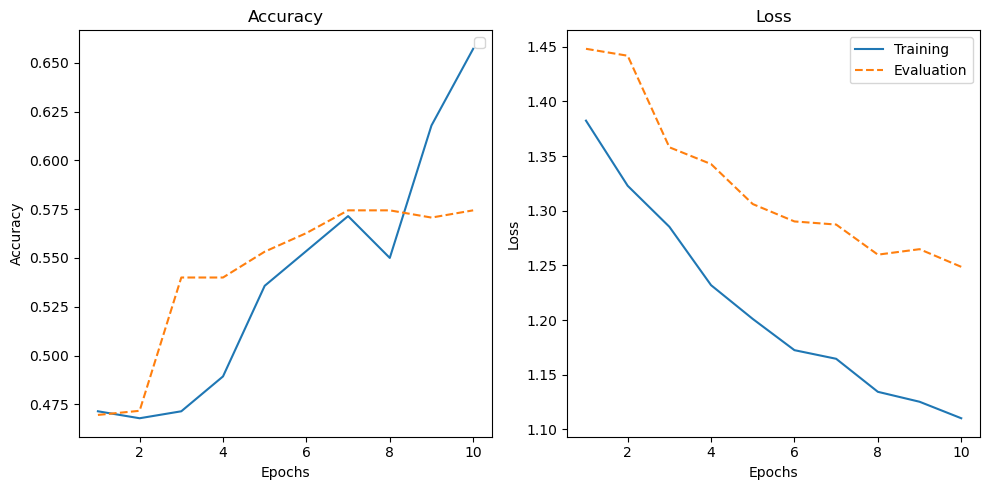

In [10]:
epochs = range(1, num_epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axes[0].plot(epochs, train_accs, linestyle='-')
axes[0].plot(epochs, eval_accs, linestyle='--')
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# Loss
axes[1].plot(epochs, train_losses, label="Training", linestyle='-')
axes[1].plot(epochs, eval_losses, label="Evaluation", linestyle='--')
axes[1].set_title("Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show();

In [11]:
test_acc, test_loss = evaluate(lenet_model , criterion , test_dataloader)
test_acc, test_loss

(0.5623342175066313, 1.243166022002697)